# Compile and Deploy the pretrained PyTorch model from model zoo with SageMaker Neo

---

이 노트북에서는 사전 훈련된 MnasNet 기반 이미지 분류(Image classification) 모델을 SageMaker Neo로 컴파일하여 배포합니다. SageMaker Neo는 머신 러닝 모델을 하드웨어에 맞게 최적화하는 API로, Neo로 컴파일한 모델은 클라우드와 엣지 디바이스 어디에서나 실행할 수 있습니다.

SageMaker Neo에서 지원하는 인스턴스 유형, 하드웨어 및 딥러닝 프레임워크는 아래 링크를 참조하세요.
(본 예제 코드는 2021년 2월 기준으로 작성되었으며, 작성 시점에서 PyTroch 1.8.0까지 지원하고 있습니다. 단, AWS Inferentia 기반 인스턴스로 배포 시에는 PyTorch 1.7.1까지 지원합니다.)

SageMaker Neo가 지원하는 인스턴스 타입, 하드웨어 및 딥러닝 프레임워크는 아래 링크를 참조해 주세요.
- 클라우드 인스턴스: https://docs.aws.amazon.com/sagemaker/latest/dg/neo-supported-cloud.html
- 엣지 디바이스: https://docs.aws.amazon.com/sagemaker/latest/dg/neo-supported-devices-edge.html

In [1]:
%load_ext autoreload
%autoreload 2

In [29]:
import sys, sagemaker, random
print(sagemaker.__version__)

2.73.0


<br>

## 1. Inference script
---

아래 코드 셀은 `src` 디렉토리에 SageMaker 추론 스크립트를 저장합니다.

DLR에서 자동으로 모델을 로드하기 때문에 별도의 `model_fn()`을 정의할 필요가 없습니다. 물론 커스텀 로직이 포함되었다면 `model_fn()`을 재정의할 수 있습니다.

In [3]:
%%writefile src/inference_pytorch_neo.py

import io
import json
import logging
import os
import pickle

import numpy as np
import torch
import torchvision.transforms as transforms
from PIL import Image  # Training container doesn't have this package

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
    
def transform_fn(model, payload, request_content_type='application/octet-stream', 
                 response_content_type='application/json'):

    logger.info('Invoking user-defined transform function')

    if request_content_type != 'application/octet-stream':
        raise RuntimeError(
            'Content type must be application/octet-stream. Provided: {0}'.format(request_content_type))

    # preprocess
    decoded = Image.open(io.BytesIO(payload))
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[
                0.485, 0.456, 0.406], std=[
                0.229, 0.224, 0.225]),
    ])
    normalized = preprocess(decoded)
    batchified = normalized.unsqueeze(0)

    # predict
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    batchified = batchified.to(device)
    result = model.forward(batchified)

    # Softmax (assumes batch size 1)
    result = np.squeeze(result.detach().cpu().numpy())
    result_exp = np.exp(result - np.max(result))
    result = result_exp / np.sum(result_exp)

    response_body = json.dumps(result.tolist())

    return response_body, response_content_type

Overwriting src/inference_pytorch_neo.py


<br>

## 2. Import pre-trained model from TorchVision
---
본 예제는 TorchVision의 pre-trained 모델 중 MnasNet을 사용합니다.
MnasNet은 정확도(accuracy)와 모바일 디바이스의 latency를 모두 고려한 강화학습 기반 NAS(neural architecture search)이며, TorchVision은 image classification에 최적화된 MNasNet-B1을 내장하고 있습니다. 
(참조 논문: https://arxiv.org/pdf/1807.11626.pdf)

In [4]:
import torch
import torchvision.models as models
import tarfile

model = models.mnasnet1_0(pretrained=True)

input_shape = [1,3,224,224]
trace = torch.jit.trace(model.float().eval(), torch.zeros(input_shape).float())
trace.save('model.pth')

### Local Inference without Endpoint

충분한 검증 및 테스트 없이 훈련된 모델을 곧바로 실제 운영 환경에 배포하기에는 많은 위험 요소들이 있기 때문에, 로컬 환경 상에서 추론을 수행하면서 디버깅하는 것을 권장합니다. 아래 코드 셀의 코드를 예시로 참조해 주세요.

In [5]:
def get_inference(img_path, predictor, show_img=True):
    with open(img_path, mode='rb') as file:
        payload = bytearray(file.read())

    response = predictor.predict(payload)
    result = json.loads(response.decode())
    pred_cls_idx, pred_cls_str, prob = parse_result(result, show_img)
    
    return pred_cls_idx, pred_cls_str, prob 

def parse_result(result, show_img=True):
    pred_cls_idx = np.argmax(result)
    pred_cls_str = label_map[str(pred_cls_idx)]
    prob = np.amax(result)*100
    
    if show_img:
        import cv2
        import matplotlib.pyplot as plt
        im = cv2.imread(img_path, cv2.COLOR_BGR2RGB)
        font = cv2.FONT_HERSHEY_COMPLEX_SMALL
        cv2.putText(im, f'{pred_cls_str} {prob:.2f}%', (10,40), font, 1, (0, 255, 0), 2, cv2.LINE_AA)
        plt.figure(figsize=(10, 10))
        plt.imshow(im[:,:,::-1])    

    return pred_cls_idx, pred_cls_str, prob

모델 배포가 완료되었으면, 추론을 수행해 보겠습니다. COCO dataset 2017 Test 이미지를 몇 장 준비했습니다.

In [40]:
import os
import json
import numpy as np
from io import BytesIO
from PIL import Image
from src.inference_pytorch_neo import transform_fn

path = "./samples"
img_list = os.listdir(path)
img_path_list = [os.path.join(path, img) for img in img_list]

#test_idx = random.randint(0, len(img_list)-1)
test_idx = 0
img_path = img_path_list[test_idx]

with open(img_path, mode='rb') as file:
    payload = bytearray(file.read())

클래스 인덱스에 대응하는 클래스명을 매핑하기 위한 딕셔너리를 생성합니다.

In [41]:
from src.utils import get_label_map_imagenet
label_file = 'metadata/imagenet1000_clsidx_to_labels.txt'
label_map = get_label_map_imagenet(label_file)

(963, " 'pizza pizza pie'", 98.97105097770691)

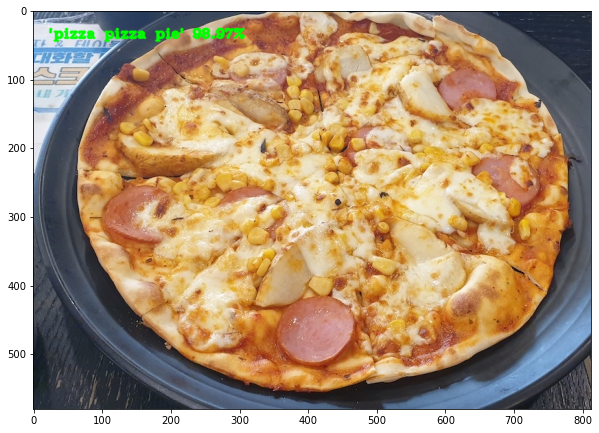

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.jit.load('model.pth')
model = model.to(device)

response_body, _ = transform_fn(model, payload)
result = json.loads(response_body)
parse_result(result)

<br>

## 3. Compile the Model
---

### 모델 압축

In [9]:
with tarfile.open('model.tar.gz', 'w:gz') as f:
    f.add('model.pth')

In [10]:
import boto3
import sagemaker
import time
from sagemaker.utils import name_from_base

role = sagemaker.get_execution_role()
sess = sagemaker.Session()
region = sess.boto_region_name
bucket = sess.default_bucket()

compilation_job_name = name_from_base('TorchVision-MNasNet-Neo')
prefix = compilation_job_name+'/model'

model_path = sess.upload_data(path='model.tar.gz', key_prefix=prefix)

data_shape = '{"input0":[1,3,224,224]}'
target_device = 'ml_c5'
framework = 'PYTORCH'
framework_version = '1.8'
compiled_model_path = 's3://{}/{}/output'.format(bucket, compilation_job_name)

### 모델 컴파일
SageMaker Neo로 모델을 컴파일합니다. 컴파일된 모델은 s3에 저장되며, 타겟 디바이스 나 타겟 인스턴스에 곧바로 배포할 수 있습니다. 타겟 디바이스 배포 시에는 Neo-DLR 패키지를 이용해 컴파일된 모델을 추론할 수 있습니다. 컴파일된 모델 아티팩트의 경로는 AWS 웹사이트의 SageMaker UI에서도 확인할 수 있고 `compiled_model.model_data`로 가져올 수도 있습니다.
<br>

참조: https://github.com/neo-ai/neo-ai-dlr


In [11]:
from sagemaker.pytorch.model import PyTorchModel
from sagemaker.predictor import Predictor

sagemaker_model = PyTorchModel(
    model_data=model_path,
    predictor_cls=Predictor,
    framework_version = framework_version,
    role=role,
    sagemaker_session=sess,
    source_dir='src',
    entry_point='inference_pytorch_neo.py',
    py_version='py3',
    env={'MMS_DEFAULT_RESPONSE_TIMEOUT': '500'}
)

In [12]:
%%time
compiled_model = sagemaker_model.compile(
    target_instance_family=target_device, 
    input_shape=data_shape,
    job_name=compilation_job_name,
    role=role,
    compile_max_run=600,
    framework=framework.lower(),
    framework_version=framework_version,
    output_path=compiled_model_path
)

???????????????????????????????.............................................!CPU times: user 245 ms, sys: 36.6 ms, total: 282 ms
Wall time: 6min 30s


### 모델 배포

SageMaker가 관리하는 배포 클러스터를 프로비저닝하고 추론 컨테이너를 배포하기 때문에, 추론 서비스를 시작하는 데에는 약 5~10분 정도 소요됩니다.

In [14]:
%%time
# account_map = {
#     'us-east-1': '785573368785',
#     'us-east-2': '007439368137',
#     'us-west-1': '710691900526',
#     'us-west-2': '301217895009',
#     'ap-northeast-1': '941853720454',
#     'ap-northeast-2': '151534178276'
# }

# image_uri = f'{account_map[region]}.dkr.ecr.{region}.amazonaws.com/sagemaker-inference-pytorch:1.8-cpu-py3'

predictor = compiled_model.deploy(
    initial_instance_count = 1,
    #image_uri=image_uri,
    instance_type = 'ml.c5.xlarge',
)

----------!CPU times: user 1.52 s, sys: 139 ms, total: 1.66 s
Wall time: 5min 3s


<br>

# 4. Inference
---

모델 배포가 완료되었으면, 추론을 수행해 보겠습니다. 저자가 직접 촬영한 테스트 이미지를 3장 준비했습니다.

In [18]:
import os
import json
import numpy as np
from io import BytesIO
from PIL import Image

img_list = os.listdir(path)
img_path_list = [os.path.join(path, img) for img in img_list]
print(img_path_list)

['./samples/pizza.jpg', './samples/bus.jpg', './samples/strawberry.jpg']


test_idx를 0~2까지 변경하면서 테스트해 보세요.

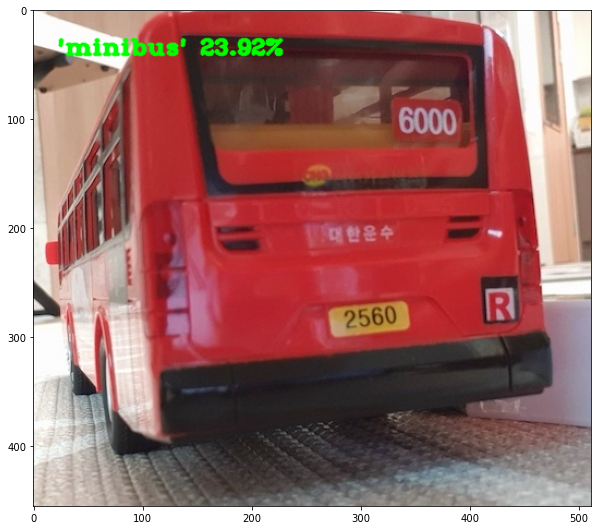

In [43]:
test_idx = random.randint(0, len(img_list)-1)
img_path = img_path_list[test_idx]
pred_cls_idx, pred_cls_str, prob = get_inference(img_path, predictor)

마지막으로 latency를 측정합니다. 본 예제는 CPU만으로 추론을 수행해도 충분합니다.

In [23]:
import time
start = time.time()
for _ in range(10):
    response = predictor.predict(payload)
neo_inference_time = (time.time()-start)
print(f'Neo optimized inference time is {neo_inference_time:.4f} s')

Neo optimized inference time is 0.6162 s


## Endpoint Clean-up

SageMaker Endpoint로 인한 과금을 막기 위해, 본 핸즈온이 끝나면 반드시 Endpoint를 삭제해 주시기 바랍니다.

In [45]:
predictor.delete_endpoint()